<a href="https://colab.research.google.com/github/owend23/ML/blob/main/algorithm_chains_and_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For many machine learning algorithms, the particular representation of the data that
you provide is very important, as we discussed in Chapter 4. This starts with scaling
the data and combining features by hand and goes all the way to learning features
using unsupervised machine learning, as we saw in Chapter 3. Consequently, most
machine learning applications require not only the application of a single algorithm,
but the chaining together of many different processing steps and machine learning
models. In this chapter, we will cover how to use the Pipeline class to simplify the
process of building chains of transformations and models. In particular, we will see
how we can combine Pipeline and GridSearchCV to search over parameters for all
processing steps at once.
As an example of the importance of chaining models, we noticed that we can greatly
improve the performance of a kernel SVM on the cancer dataset by using the Min
MaxScaler for preprocessing. Here’s code for splitting the data, computing the minimum
and maximum, scaling the data, and training the SVM:

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# Compute the minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# Learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


# Parameter Selection with Preprocessing

A naive approach might
look like this:

In [4]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, dont use this code!!!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


Here, we ran the grid search over the parameters of SVC using the scaled data. However,
there is a subtle catch in what we just did. When scaling the data, we used all the
data in the training set to find out how to train it. We then use the scaled training data
to run our grid search using cross-validation. For each split in the cross-validation,
some part of the original training set will be declared the training part of the split,
and some the test part of the split. The test part is used to measure what new data will
look like to a model trained on the training part. However, we already used the information
contained in the test part of the split, when scaling the data. Remember that
the test part in each split in the cross-validation is part of the training set, and we
used the information from the entire training set to find the right scaling of the data.

This is fundamentally different from how new data looks to the model. If we observe
new data (say, in form of our test set), this data will not have been used to scale the
training data, and it might have a different minimum and maximum than the training
data. The following example (Figure 6-1) shows how the data processing during
cross-validation and the final evaluation differ:

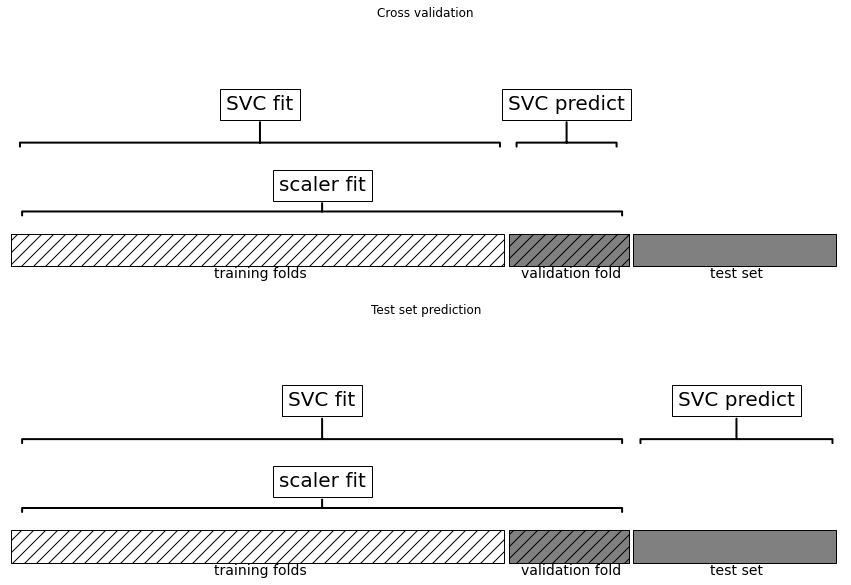

In [6]:
import mglearn

mglearn.plots.plot_improper_processing()

So, the splits in the cross-validation no longer correctly mirror how new data will
look to the modeling process. We already leaked information from these parts of the
data into our modeling process. This will lead to overly optimistic results during
cross-validation, and possibly the selection of suboptimal parameters.


To get around this problem, the splitting of the dataset during cross-validation should
be done before doing any preprocessing. Any process that extracts knowledge from the
dataset should only ever be applied to the training portion of the dataset, so any
cross-validation should be the “outermost loop” in your processing.

To achieve this in scikit-learn with the cross_val_score function and the Grid
SearchCV function, we can use the Pipeline class. The Pipeline class is a class that
allows “gluing” together multiple processing steps into a single scikit-learn estimaor. The Pipeline class itself has fit, predict, and score methods and behaves just like any other model in scikit-learn. The most common use case of the Pipeline class is in chaining preprocessing steps (like scaling of the data) together with a supervised model like a classifier

# Building Pipelines

Let’s look at how we can use the Pipeline class to express the workflow for training
an SVM after scaling the data with MinMaxScaler (for now without the grid search).
First, we build a pipeline object by providing it with a list of steps. Each step is a tuple
containing a name (any string of your choosing1) and an instance of an estimator:

In [7]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Here, pipe.fit first calls fit on the first step (the scaler), then transforms the training
data using the scaler, and finally fits the SVM with the scaled data

In [8]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


Calling the score method on the pipeline first transforms the test data using the
scaler, and then calls the score method on the SVM using the scaled test data. As you
can see, the result is identical to the one we got from the code at the beginning of the
chapter, when doing the transformations by hand. Using the pipeline, we reduced the
code needed for our “preprocessing + classification” process. The main benefit of
using the pipeline, however, is that we can now use this single estimator in
cross_val_score or GridSearchCV.

# Using Pipelines in Grid Searches

In [9]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


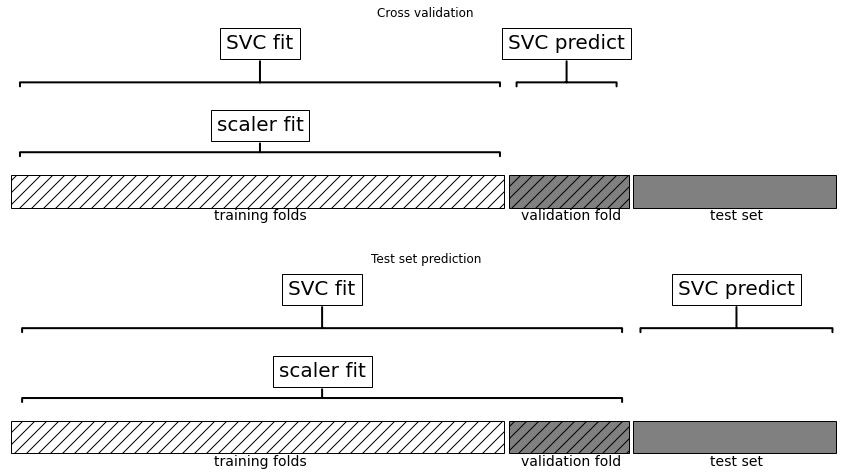

In [10]:
mglearn.plots.plot_proper_processing()

### Illustrating Information Leakage

In [11]:
import numpy as np
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [12]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
    np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


The mean R2 computed by cross-validation is 0.91, indicating a very good model.
This clearly cannot be right, as our data is entirely random. What happened here is
that our feature selection picked out some features among the 10,000 random features
that are (by chance) very well correlated with the target. Because we fit the feature
selection outside of the cross-validation, it could find features that are correlated both
on the training and the test folds. The information we leaked from the test folds was
very informative, leading to highly unrealistic results. Let’s compare this to a proper
cross-validation using a pipeline:

In [15]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                 ('ridge', Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
    np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


This time, we get a negative R2 score, indicating a very poor model. Using the pipeline,
the feature selection is now inside the cross-validation loop. This means features
can only be selected using the training folds of the data, not the test fold. The feature
selection finds features that are correlated with the target on the training set, but
because the data is entirely random, these features are not correlated with the target
on the test set. In this example, rectifying the data leakage issue in the feature selection
makes the difference between concluding that a model works very well and concluding
that a model works not at all.

# The General Pipeline Interface

The Pipeline class is not restricted to preprocessing and classification, but can in fact join any number of estimators together. For example you could build a pipeline containing feature extraction, feature selection, scaling, and classification, for a total of four steps. Similarly, the last step could be regression or clustering instead of classification.

* The only requirements for estimators in a pipeline is that all but the last step need to have a transform method, so they can produce a new representation of the data that can be used in the next step.

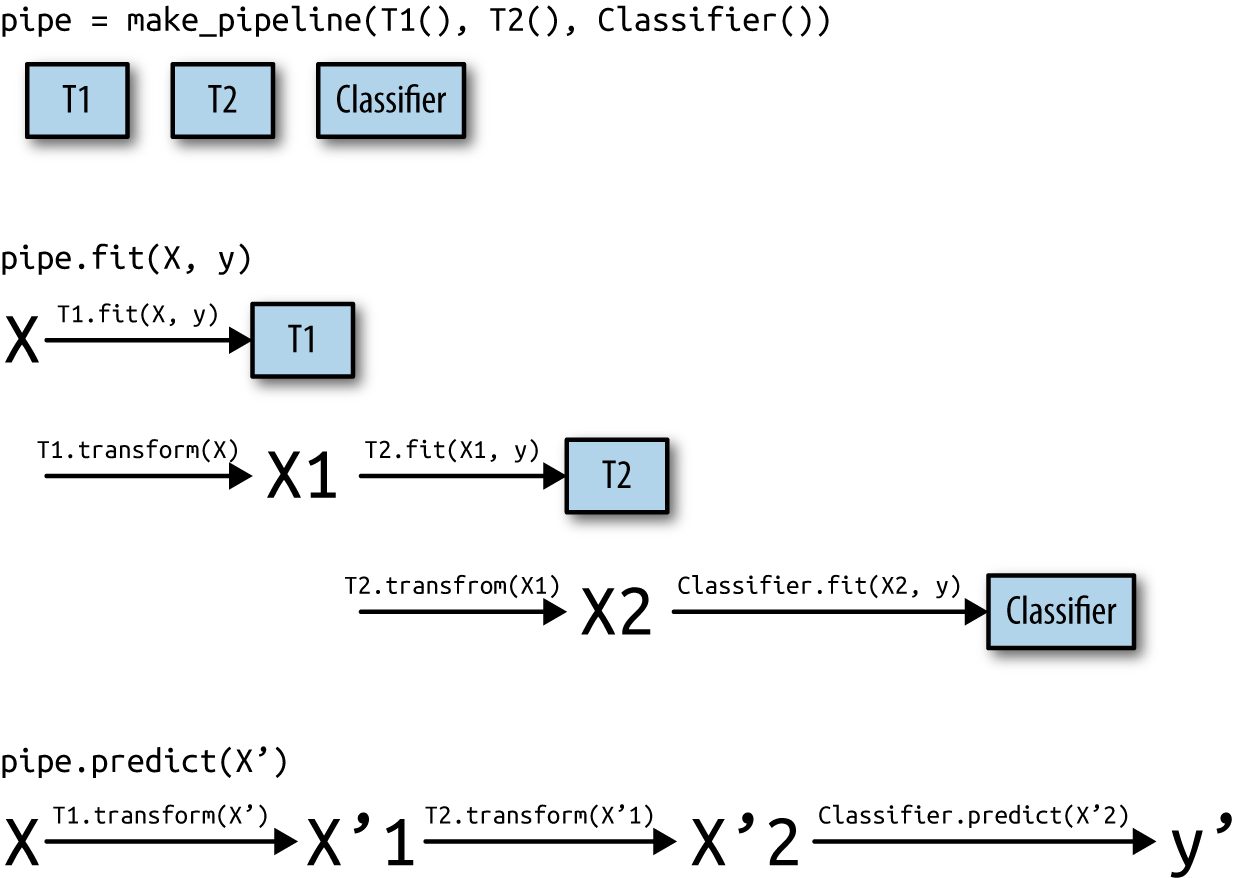

## Convenient Pipeline Creation with make_pipeline

Creating a pipeline using the syntax described earlier is sometimes a bit cumbersome, and we often don't need user-specified names for each step. There is a convenience function, make_pipeline, that will create a pipeline for us and automatically name each step based on its class

In [18]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [19]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


## Accessing Step Attributes

Often you will want to inspect attributes of one of the steps of the pipeline--say, the coefficients of a linear model or the components extracted by PCA. The easiest way to access the steps in a pipeline is via the named_steps attribute, which is a dictionary from the step names to the estimators:

In [21]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first twp principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


## Accessing Attributes in a Grid-Searched Pipeline

As we discussed earlier in this chapter, one of the main reasons to use pipelines is for
doing grid searches. A common task is to access some of the steps of a pipeline inside
a grid search. Let’s grid search a LogisticRegression classifier on the cancer dataset,
using Pipeline and StandardScaler to scale the data before passing it to the Logisti
cRegression classifier. First we create a pipeline using the make_pipeline function:

In [24]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

Next, we create a parameter grid

In [25]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [26]:
print("Logistic regression step:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [28]:
print("Logistic regression coefficients:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"].coef_
))

Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


# Grid-Searching Preprocessing Steps and Model Parameters
Using pipelines, we can encapsulate all the processing steps in our machine learning
workflow in a single scikit-learn estimator. Another benefit of doing this is that we
can now adjust the parameters of the preprocessing using the outcome of a supervised
task like regression or classification. In previous chapters, we used polynomial features
on the boston dataset before applying the ridge regressor. Let’s model that using
a pipeline instead. The pipeline contains three steps—scaling the data, computing
polynomial features, and ridge regression:

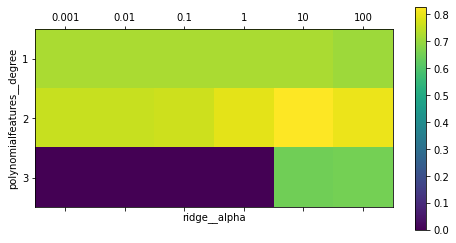

In [31]:
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train)

plt.matshow(grid.cv_results_["mean_test_score"].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid["ridge__alpha"])), param_grid["ridge__alpha"])
plt.yticks(range(len(param_grid["polynomialfeatures__degree"])), param_grid["polynomialfeatures__degree"])
plt.colorbar()

In [32]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [33]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [34]:
# Grid search without polynomial features for comparison
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


# Grid-Searching Which Model To Use

You can even go further in combining GridSearchCV and Pipeline: it is also possible
to search over the actual steps being performed in the pipeline (say whether to use
StandardScaler or MinMaxScaler). This leads to an even bigger search space and
should be considered carefully. Trying all possible solutions is usually not a viable
machine learning strategy. However, here is an example comparing a RandomForest
Classifier and an SVC on the iris dataset. We know that the SVC might need the
data to be scaled, so we also search over whether to use StandardScaler or no preprocessing.
For the RandomForestClassifier, we know that no preprocessing is necessary.
We start by defining the pipeline. Here, we explicitly name the steps. We want
two steps, one for the preprocessing and then a classifier. We can instantiate this
using SVC and StandardScaler:

In [38]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

Now we can define the parameter_grid to search over. We want the classifier to
be either RandomForestClassifier or SVC. Because they have different parameters to
tune, and need different preprocessing, we can make use of the list of search grids we
discussed

In [39]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
{'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
{'classifier': [RandomForestClassifier(n_estimators=100)],
'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [40]:
# Now we can instantiate and run the grid search as usual, here on the cancer dataset
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98
